In [331]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    cross_val_score, GridSearchCV)
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [332]:
data=pd.read_csv("data.csv")

In [333]:
data.head()

,Sentence,Category
0,insurance price for a skoda marathon,1
1,are you a unit,6
2,we put down out a debt for our wheeled Monterey,3
3,i do not need a claim from you the other compa...,5
4,i take insurance for my car,1


In [334]:
data.describe(include=['object'])

,Sentence,Category
count,38941,38941
unique,38398,27
top,jo jones 45 8876 cedar 11091973 married,15
freq,9,16004


In [335]:
data['Category'].value_counts()

15         16004
2           5688
3           3544
1           1990
9           1418
8           1228
6           1176
16          1010
0            906
7            795
1, 3         647
13           561
1, 2, 3      521
2, 3         472
5            432
4            423
1, 2         369
12           297
23           272
10           217
11           196
19           150
18           150
17           149
14           138
20           105
21            83
Name: Category, dtype: int64

In [336]:
x_train, x_test, y_train, y_test =train_test_split(data["Sentence"], data["Category"],test_size=0.2,train_size=0.8)

In [337]:
word_vectorizer=TfidfVectorizer(min_df=25)

In [338]:
word_vectorizer.fit(data["Sentence"])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=25,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [339]:
train_word_features=word_vectorizer.transform(x_train)
test_word_features=word_vectorizer.transform(x_test)

In [340]:
skf = StratifiedKFold(n_splits=5)

In [341]:
classifier = LogisticRegression(max_iter=100)

In [342]:
params={
    'C' : np.arange(50,80,10),
    'solver' : ['newton-cg', 'lbfgs', 'sag', 'saga']
}

In [343]:
gs = GridSearchCV(
    estimator=classifier,  # base model
    param_grid=params,  # params grid to search within
    cv=skf,  # cross-validation strategy
    error_score=1,  # warnings only
    scoring='accuracy',  # f1_weighted-score
)

In [344]:
gs.fit(train_word_features, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score=1,
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([50, 60, 70]), 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [345]:
gs.best_params_

{'C': 50, 'solver': 'lbfgs'}

In [346]:
classifier = LogisticRegression(C=70.0, solver = 'saga', max_iter=100)

In [347]:
classifier.fit(train_word_features, y_train)

LogisticRegression(C=70.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)

In [348]:
classifier.score(test_word_features, y_test)

0.94761843625625886

dependence of the error on the amount of data

In [349]:
train_sizes=np.arange(0.1, 0.81, 0.1)
classifier_score_test=[]
classifier_score_train=[]
for train_size in train_sizes:
    x_train, x_test, y_train, y_test =train_test_split(data["Sentence"], 
                                                           data["Category"],test_size=0.2,train_size=train_size)
    train_word_features=word_vectorizer.transform(x_train)
    test_word_features=word_vectorizer.transform(x_test)
    classifier.fit(train_word_features, y_train)
    classifier_score_test.append(classifier.score(test_word_features, y_test))
    score_train=np.mean(cross_val_score(classifier, train_word_features, y_train, cv=skf, scoring='accuracy'))
    classifier_score_train.append(score_train)

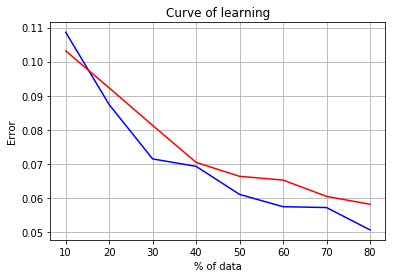

In [350]:
error_test=list(map(lambda x: 1-x, classifier_score_test))
error_train=list(map(lambda x: 1-x, classifier_score_train))
train_sizes=np.arange(10, 81, 10)

plt.plot(train_sizes, error_test, 'b', train_sizes, error_train, 'r')

plt.title('Curve of learning')
plt.ylabel('Error')
plt.xlabel('% of data')

plt.grid(True)

plt.show()


We can make the error less, if we incrase the amount of data, especially if it is data from groups where there is little data.